In [ ]:
!pip install -q pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00


In [ ]:
import re
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel

In [ ]:
df = pd.read_csv("fulldata1027.csv")

In [ ]:
df.rename(columns={
    "Unnamed: 0": "index",
    "id": "video_id",
    "authorMeta/digg": "author_likes",
    "authorMeta/fans": "author_fans",
    "authorMeta/heart": "author_hearts",
    "webVideoUrl": "video_url",
    "isAd": "is_ad",
    "isSponsored": "is_sponsored",
    "playCount": "play_count",
    "diggCount": "like_count",
    "commentCount": "comment_count",
    "shareCount": "share_count",
    "videoMeta/duration": "duration_sec",
    "videoMeta/subtitleLinks/1/downloadLink": "subtitle_url",
    "text": "video_caption",
    "script_video": "video_script"
}, inplace=True)

In [ ]:
cols_to_drop = [
    "index",
    "video_id",
    "author_likes",
    "author_hearts",
    "video_url",
    "duration_sec",
    "subtitle_url"
]

df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df["is_ad"] = df["is_ad"].astype(int)
df["is_sponsored"] = df["is_sponsored"].astype(int)

In [ ]:
df["video_script"] = df["video_script"].str.replace("\r\n", " ", regex=False)

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["video_caption"] = df["video_caption"].apply(clean_text)
df["video_script"] = df["video_script"].apply(clean_text)

In [ ]:
df["caption_tok"] = df["video_caption"].apply(ViTokenizer.tokenize)
df["script_tok"] = df["video_script"].apply(ViTokenizer.tokenize)

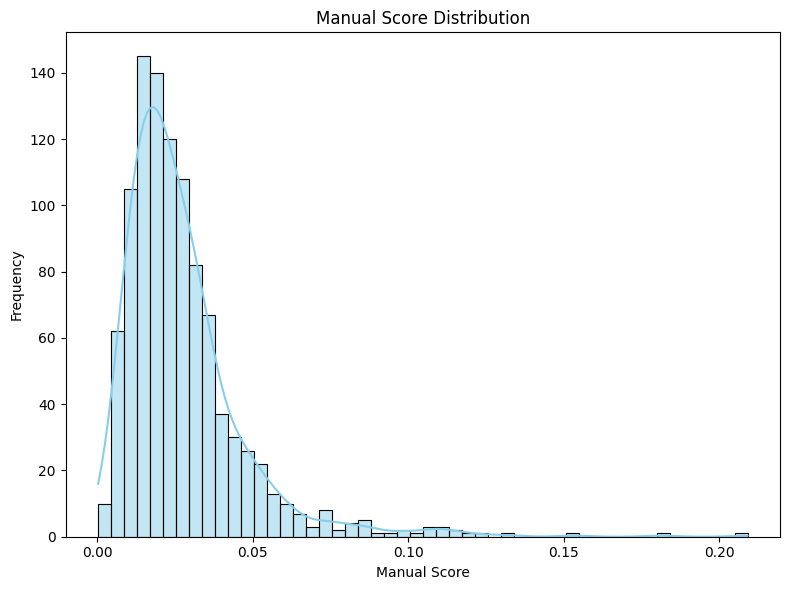

In [ ]:
df["manual_score"] = (df["like_count"] + df["share_count"] + df["comment_count"]) / (df["play_count"])

plt.figure(figsize=(8, 6))
sns.histplot(df["manual_score"], bins=50, kde=True, color="skyblue")
plt.title("Manual Score Distribution")
plt.xlabel("Manual Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

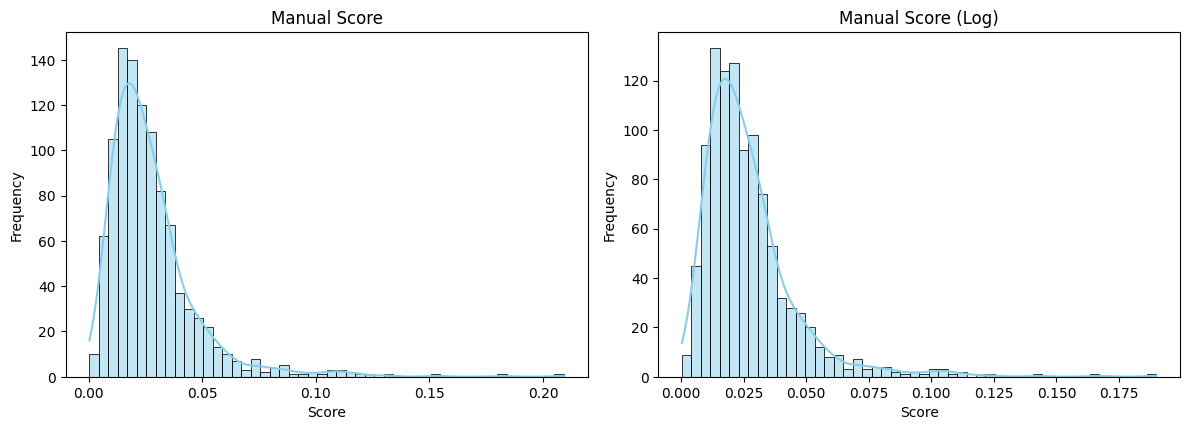

In [ ]:
df["manual_score_log"] = np.log1p(df["manual_score"])

plt.figure(figsize=(12, 8))
scores = ["manual_score", "manual_score_log"]
titles = ["Manual Score", "Manual Score (Log)"]

for i, score in enumerate(scores):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[score], bins=50, kde=True, color="skyblue")
    plt.title(titles[i])
    plt.xlabel("Score")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
features = ["comment_count", "like_count", "share_count", "play_count"]
raw_data = df[features].values

def compute_pca_scores(data, score_col_name, threshold=0.95):
    pca_temp = PCA(threshold)
    pca_temp.fit(data)
    k = pca_temp.n_components_

    pca = PCA(n_components=k, random_state=42)
    x_pca = pca.fit_transform(data)

    weights = pca.explained_variance_ratio_
    weights /= weights.sum()

    scores = np.dot(x_pca, weights)
    df[score_col_name] = scores

compute_pca_scores(raw_data, score_col_name="pca_score_raw")

scaler = StandardScaler()
scaled_data = scaler.fit_transform(raw_data)
compute_pca_scores(scaled_data, score_col_name="pca_score_std")

In [ ]:
for col in ["manual_score", "manual_score_log", "pca_score_std"]:
    df[f"{col}_class_qcut"] = pd.qcut(df[col], q=3, labels=["low", "medium", "high"])

    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(df[[col]])

    cluster_means = pd.DataFrame({'cluster': np.unique(clusters)})
    cluster_means['mean'] = cluster_means['cluster'].apply(lambda c: df.loc[clusters == c, col].mean())
    cluster_means = cluster_means.sort_values('mean').reset_index(drop=True)
    cluster_map = {row['cluster']: idx for idx, row in cluster_means.iterrows()}
    ordered_clusters = [cluster_map[c] for c in clusters]

    label_map = {0: 'low', 1: 'medium', 2: 'high'}
    class_col = f"{col}_class_kmeans"
    df[class_col] = pd.Series(ordered_clusters).map(label_map)

    df_low = df[df[class_col] == 'low']
    df_high = df[df[class_col] == 'high']
    df_medium = df[df[class_col] == 'medium'].sample(frac=0.3, random_state=42)
    df = pd.concat([df_low, df_medium, df_high], ignore_index=True)

In [ ]:
score_cols = ["manual_score", "manual_score_log", "pca_score_std"]
methods = ["qcut", "kmeans"]

for col in score_cols:
    print(f"\nClass distribution for column {col}:")
    for method in methods:
        class_col = f"{col}_class_{method}"
        counts = df[class_col].value_counts()
        print(f"  {method}:")
        print(counts)
        len(df)


Class distribution for column manual_score:
  qcut:
manual_score_class_qcut
low       271
medium    219
high       94
Name: count, dtype: int64
  kmeans:
manual_score_class_kmeans
low       499
medium     60
high       25
Name: count, dtype: int64

Class distribution for column manual_score_log:
  qcut:
manual_score_log_class_qcut
low       263
medium    223
high       98
Name: count, dtype: int64
  kmeans:
manual_score_log_class_kmeans
low       482
medium     69
high       33
Name: count, dtype: int64

Class distribution for column pca_score_std:
  qcut:
pca_score_std_class_qcut
low       207
medium    206
high      171
Name: count, dtype: int64
  kmeans:
pca_score_std_class_kmeans
low       563
medium     16
high        5
Name: count, dtype: int64


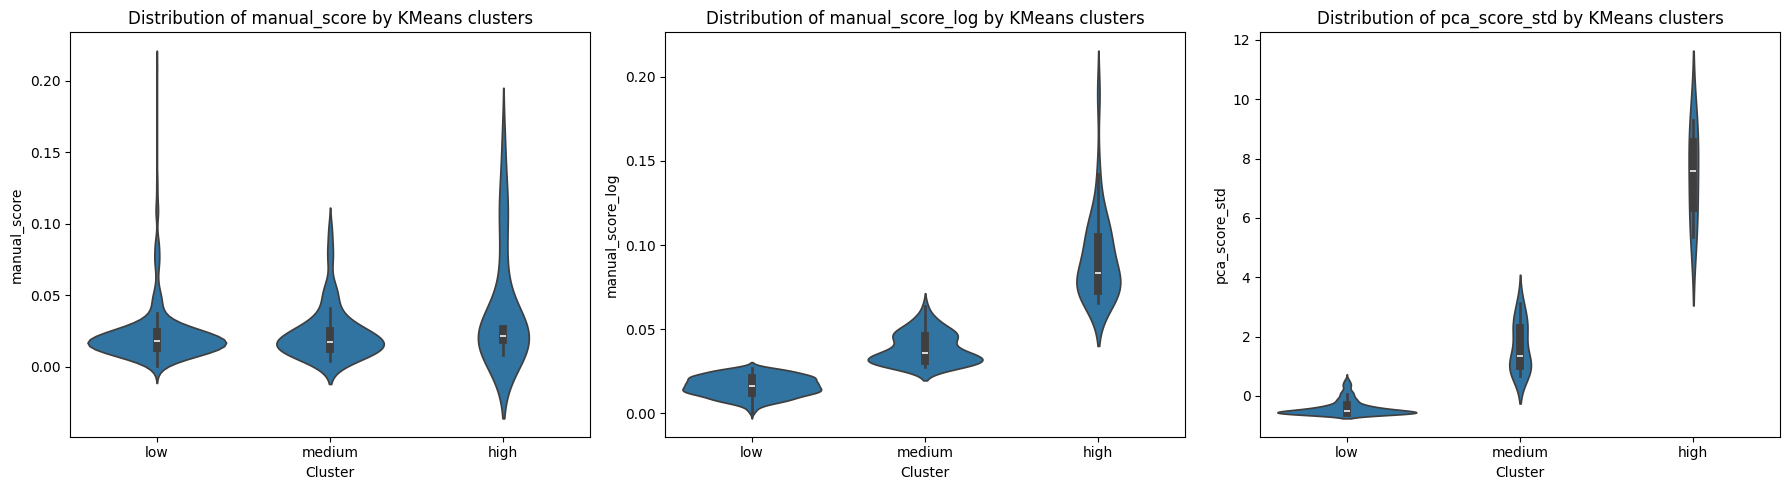

In [ ]:
plt.figure(figsize=(18, 5))

for i, col in enumerate(["manual_score", "manual_score_log", "pca_score_std"]):
    class_col = f"{col}_class_kmeans"

    plt.subplot(1, 3, i + 1)
    sns.violinplot(data=df, x=class_col, y=col, order=['low', 'medium', 'high'])
    plt.title(f'Distribution of {col} by KMeans clusters')
    plt.xlabel('Cluster')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

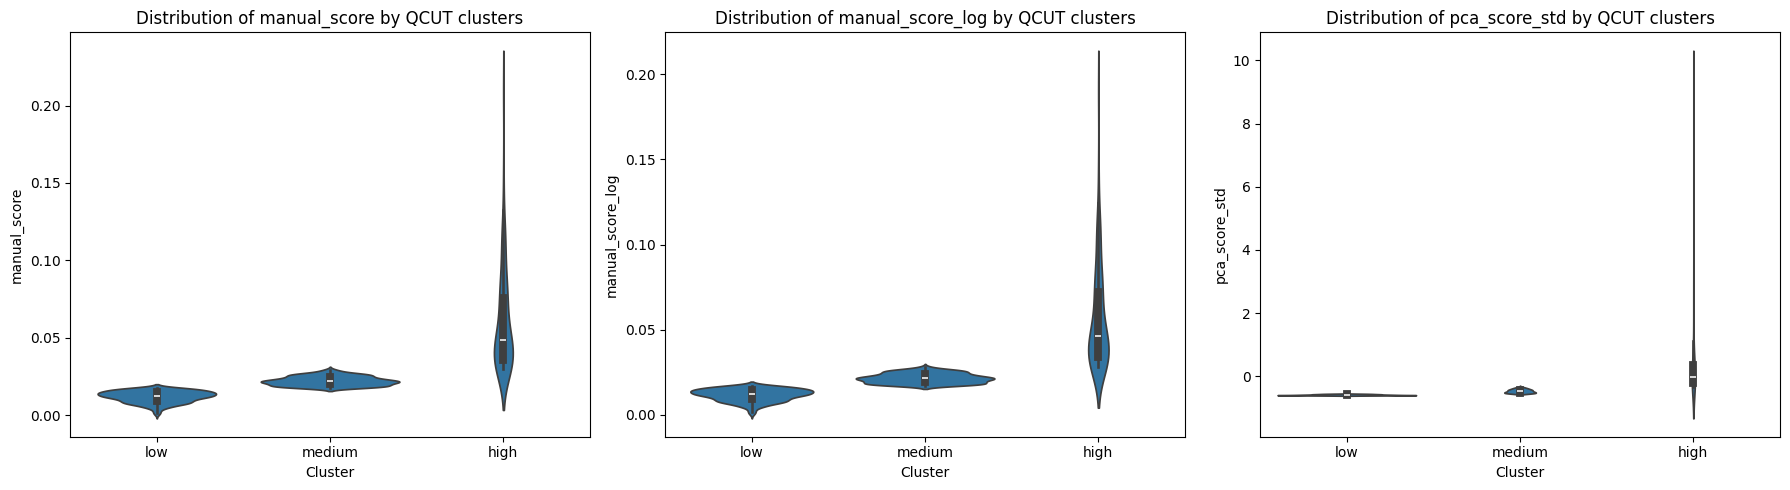

In [ ]:
plt.figure(figsize=(18, 5))

for i, col in enumerate(["manual_score", "manual_score_log", "pca_score_std"]):
    class_col = f"{col}_class_qcut"

    plt.subplot(1, 3, i + 1)
    sns.violinplot(data=df, x=class_col, y=col, order=['low', 'medium', 'high'])
    plt.title(f'Distribution of {col} by QCUT clusters')
    plt.xlabel('Cluster')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

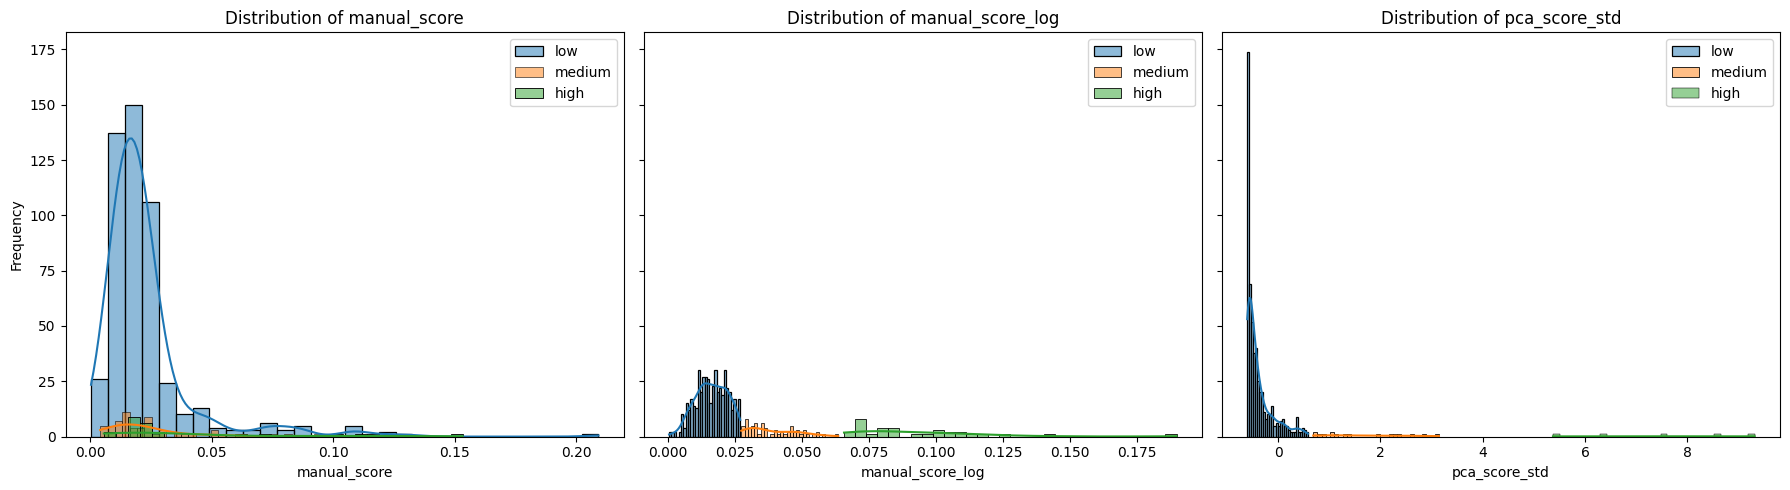

In [ ]:
cols = ["manual_score", "manual_score_log", "pca_score_std"]
labels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, len(cols), figsize=(18, 5), sharey=True)

for i, col in enumerate(cols):
    class_col = f"{col}_class_kmeans"
    ax = axes[i]

    for label in labels:
        sns.histplot(
            df[df[class_col] == label][col],
            label=label, kde=True, bins=30, alpha=0.5, ax=ax
        )

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    if i == 0:
        ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

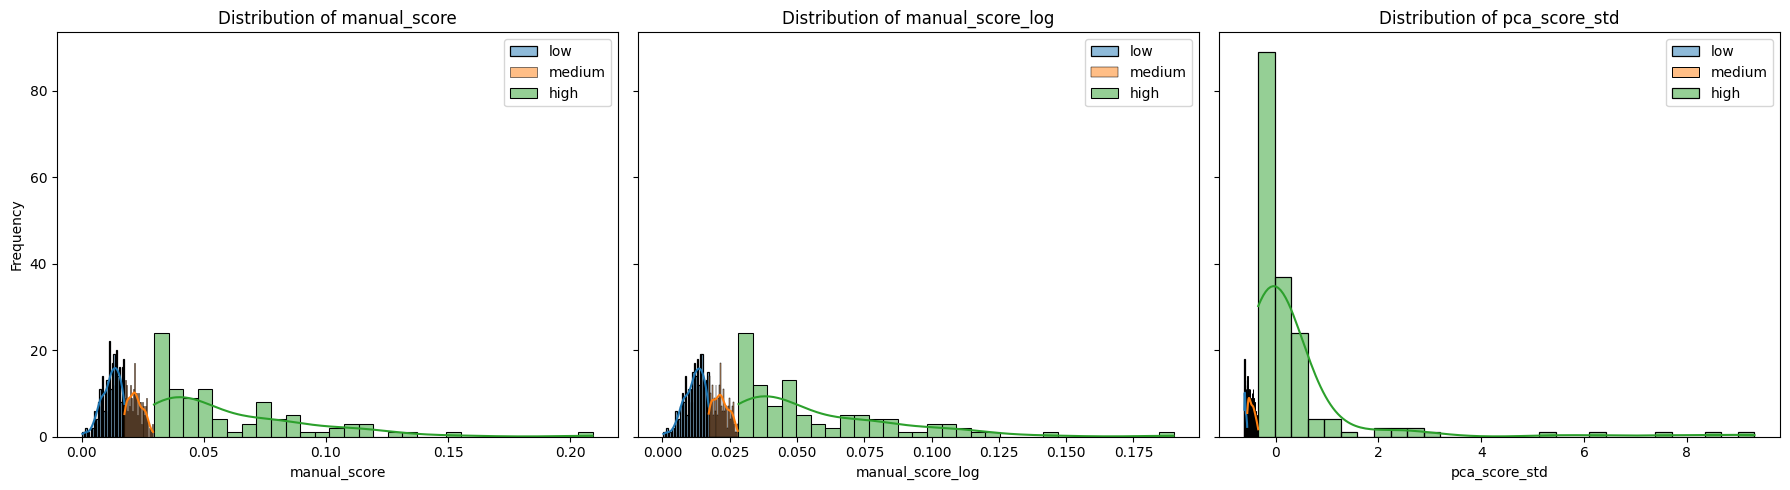

In [ ]:
cols = ["manual_score", "manual_score_log", "pca_score_std"]
labels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, len(cols), figsize=(18, 5), sharey=True)

for i, col in enumerate(cols):
    class_col = f"{col}_class_qcut"
    ax = axes[i]

    for label in labels:
        sns.histplot(
            df[df[class_col] == label][col],
            label=label, kde=True, bins=30, alpha=0.5, ax=ax
        )

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    if i == 0:
        ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
cols_to_drop = [
    "play_count", "like_count", "comment_count", "share_count",
    "video_caption", "video_script", "manual_score", "manual_score_log",
    "pca_score_raw", "pca_score_std", "manual_score_class_qcut",
    "manual_score_class_kmeans", "manual_score_log_class_qcut",
    "pca_score_std_class_qcut", "pca_score_std_class_kmeans"
]

df = df.drop(columns=cols_to_drop)

In [ ]:
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
phobert_model = AutoModel.from_pretrained("vinai/phobert-base-v2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
phobert_model.to(device)
phobert_model.eval()

def phobert_embed(text_list, tokenizer, model, max_length=256, batch_size=32):
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch = text_list[i:i+batch_size]
            encoded = tokenizer(batch, return_tensors="pt", padding=True,
                                truncation=True, max_length=max_length)
            encoded = {k: v.to(device) for k, v in encoded.items()}
            outputs = model(**encoded)
            last_hidden = outputs.last_hidden_state
            attention_mask = encoded["attention_mask"].unsqueeze(-1).expand(last_hidden.size())
            summed = torch.sum(last_hidden * attention_mask, dim=1)
            counts = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            mean_pooled = (summed / counts).cpu().numpy()
            embeddings.extend(mean_pooled)
    return np.array(embeddings)

all_captions = df["caption_tok"].tolist()
all_scripts = df["script_tok"].tolist()

embedding_caption = phobert_embed(all_captions, phobert_tokenizer, phobert_model)
embedding_script = phobert_embed(all_scripts, phobert_tokenizer, phobert_model)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df.to_csv("processed_data.csv", index=False)

In [ ]:
np.save("embedding_caption_mean.npy", embedding_caption)
np.save("embedding_script_mean.npy", embedding_script)